# Handwritten digit recognition with Keras

In [54]:
import keras
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD, RMSprop

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

## The MNIST Data

Get the data:

In [38]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Check the dimensions:

In [3]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


Look at a couple example images:

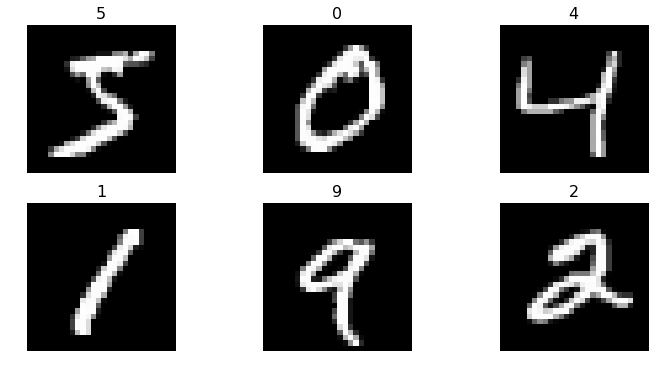

In [4]:
f = plt.figure(figsize=(12,6))
for i in range(6):
    sp = f.add_subplot(2, 3, i+1)
    sp.axis('Off')
    sp.set_title(y_train[i], fontsize=16)
    plt.imshow(x_train[i], cmap='gray')

Vectorize the images, and rescale them into a [0,1] range:

In [39]:
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

60000 train samples
10000 test samples


Convert class vectors to one-hot-encoded class matrices:

In [40]:
num_classes = 10

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

y_train[:3,]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

## Neural network with a single hidden layer

In [14]:
# This returns a tensor
inputs = Input(shape=(784,))

# a layer instance is callable on a tensor, and returns a tensor
x = Dense(15, activation='sigmoid')(inputs)
predictions = Dense(10, activation='softmax')(x)

# This creates a model that includes
# the Input layer and two Dense layers
model1 = Model(inputs=inputs, outputs=predictions)

model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 15)                11775     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                160       
Total params: 11,935
Trainable params: 11,935
Non-trainable params: 0
_________________________________________________________________


Compile and fit the model:

In [15]:
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

model1.compile(optimizer=sgd,
               loss='mean_squared_error',
               metrics=['accuracy'])

model1.fit(x_train, y_train, batch_size=32, epochs=20, verbose=1, validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 4s 73us/step - loss: 0.0873 - acc: 0.3241 - val_loss: 0.0831 - val_acc: 0.4473
Epoch 2/20
60000/60000 [==============================] - 5s 75us/step - loss: 0.0779 - acc: 0.5181 - val_loss: 0.0716 - val_acc: 0.5766
Epoch 3/20
60000/60000 [==============================] - 5s 75us/step - loss: 0.0654 - acc: 0.6071 - val_loss: 0.0592 - val_acc: 0.6311
Epoch 4/20
60000/60000 [==============================] - 5s 75us/step - loss: 0.0544 - acc: 0.6547 - val_loss: 0.0496 - val_acc: 0.6818
Epoch 5/20
60000/60000 [==============================] - 4s 75us/step - loss: 0.0464 - acc: 0.7127 - val_loss: 0.0429 - val_acc: 0.7495
Epoch 6/20
60000/60000 [==============================] - 5s 75us/step - loss: 0.0406 - acc: 0.7694 - val_loss: 0.0377 - val_acc: 0.7916
Epoch 7/20
60000/60000 [==============================] - 5s 75us/step - loss: 0.0361 - acc: 0.7945 - val_loss: 0.0336 - val_acc

Check the score on test data:

In [16]:
score = model1.evaluate(x_test, y_test, verbose=0)
print('Mean squared error on the test data:', score[0])
print('Test accuracy:', score[1])

Mean squared error on the test data: 0.016053995117545128
Test accuracy: 0.9051


Look at some of the missclassified images:

Missclassified: 949 / 10000


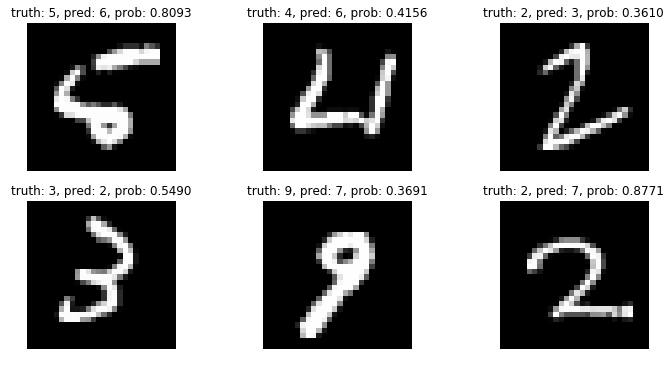

In [17]:
def display_first_6_missclassified(model):
    test_pred = model.predict(x_test)
    n_test = x_test.shape[0]
    misclassified = []

    for i in range(n_test):
        if np.argmax(test_pred[i, :]) != np.argmax(y_test[i, :]):
            misclassified.append(i)
        
    print("Missclassified: {} / {}".format(len(misclassified), n_test))

    first_6_misclassified = misclassified[:6]

    f = plt.figure(figsize=(12,6))
    for i in range(6):
        sp = f.add_subplot(2, 3, i+1)
        img_id = first_6_misclassified[i]
        sp.axis('Off')
        pred_class = np.argmax(test_pred[img_id, :])
        max_prob = np.max(test_pred[img_id, :])
        ground_truth = np.argmax(y_test[img_id, :])
        sp.set_title("truth: {}, pred: {}, prob: {:.4f}".format(ground_truth, pred_class, max_prob), fontsize=12)
        plt.imshow(x_test[img_id].reshape(28, 28), cmap='gray')
        

display_first_6_missclassified(model1)

## Add a couple more layers to the model

![Stack moar layers](https://i.redd.it/5193db0avbey.jpg)

In [22]:
inputs = Input(shape=(784,))

x = Dense(64, activation='sigmoid')(inputs)
x = Dense(64, activation='sigmoid')(x)
x = Dense(64, activation='sigmoid')(x)
predictions = Dense(10, activation='softmax')(x)

model2 = Model(inputs=inputs, outputs=predictions)

model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                50240     
_________________________________________________________________
dense_13 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_14 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_15 (Dense)             (None, 10)                650       
Total params: 59,210
Trainable params: 59,210
Non-trainable params: 0
_________________________________________________________________


In [23]:
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True) # 10x the learning rate of last model

model2.compile(loss='mean_squared_error',
               optimizer=sgd,
               metrics=['accuracy'])

model2.fit(x_train, y_train, batch_size=128, epochs=40, verbose=1, validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/40
60000/60000 [==============================] - 1s 25us/step - loss: 0.0901 - acc: 0.1141 - val_loss: 0.0899 - val_acc: 0.1135
Epoch 2/40
60000/60000 [==============================] - 1s 22us/step - loss: 0.0899 - acc: 0.1167 - val_loss: 0.0898 - val_acc: 0.1135
Epoch 3/40
60000/60000 [==============================] - 1s 24us/step - loss: 0.0898 - acc: 0.1233 - val_loss: 0.0897 - val_acc: 0.1135
Epoch 4/40
60000/60000 [==============================] - 1s 24us/step - loss: 0.0896 - acc: 0.1362 - val_loss: 0.0895 - val_acc: 0.1162
Epoch 5/40
60000/60000 [==============================] - 1s 24us/step - loss: 0.0894 - acc: 0.1615 - val_loss: 0.0893 - val_acc: 0.1180
Epoch 6/40
60000/60000 [==============================] - 1s 24us/step - loss: 0.0891 - acc: 0.1928 - val_loss: 0.0889 - val_acc: 0.2562
Epoch 7/40
60000/60000 [==============================] - 1s 24us/step - loss: 0.0885 - acc: 0.2576 - val_loss: 0.0880 - val_acc

Lower the learning rate and train some more:

In [24]:
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True) # lower the learning rate

model2.fit(x_train, y_train, batch_size=128, epochs=20, verbose=1, validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 1s 23us/step - loss: 0.0097 - acc: 0.9384 - val_loss: 0.0097 - val_acc: 0.9364
Epoch 2/20
60000/60000 [==============================] - 1s 22us/step - loss: 0.0095 - acc: 0.9402 - val_loss: 0.0096 - val_acc: 0.9374
Epoch 3/20
60000/60000 [==============================] - 1s 24us/step - loss: 0.0092 - acc: 0.9413 - val_loss: 0.0094 - val_acc: 0.9393
Epoch 4/20
60000/60000 [==============================] - 1s 24us/step - loss: 0.0090 - acc: 0.9427 - val_loss: 0.0092 - val_acc: 0.9407
Epoch 5/20
60000/60000 [==============================] - 1s 24us/step - loss: 0.0088 - acc: 0.9443 - val_loss: 0.0091 - val_acc: 0.9415
Epoch 6/20
60000/60000 [==============================] - 1s 24us/step - loss: 0.0086 - acc: 0.9461 - val_loss: 0.0089 - val_acc: 0.9423
Epoch 7/20
60000/60000 [==============================] - 1s 24us/step - loss: 0.0084 - acc: 0.9471 - val_loss: 0.0088 - val_acc

In [25]:
score = model2.evaluate(x_test, y_test, verbose=0)
print('Mean squared error on the test data:', score[0])
print('Test accuracy:', score[1])

Mean squared error on the test data: 0.007170853802200872
Test accuracy: 0.9538


Missclassified: 462 / 10000


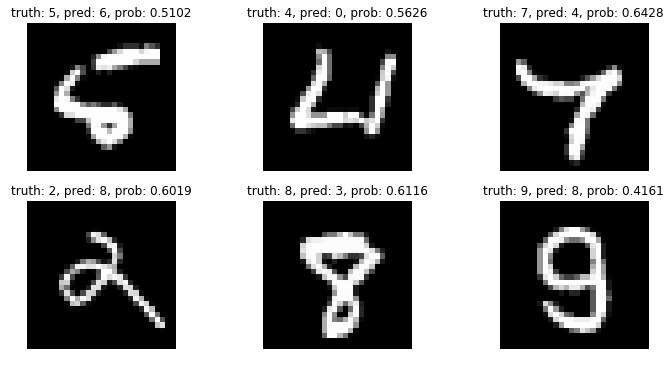

In [26]:
display_first_6_missclassified(model2)

## Categorical crossentropy, ReLU activations, dropout, RMSProp optimizer

Build the model:

In [41]:
inputs = Input(shape=(784,))
x = Dense(512, activation='relu')(inputs)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)
predictions = Dense(10, activation='softmax')(x)

model3 = Model(inputs=inputs, outputs=predictions)

model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 512)               401920    
_________________________________________________________________
dropout_13 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_14 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_15 (Dropout)         (None, 128)               0         
__________

In [42]:
model3.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

model3.fit(x_train, y_train,
           batch_size=128,
           epochs=20,
           verbose=1,
           validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 2s 40us/step - loss: 0.3954 - acc: 0.8797 - val_loss: 0.1287 - val_acc: 0.9606
Epoch 2/20
60000/60000 [==============================] - 2s 32us/step - loss: 0.1760 - acc: 0.9499 - val_loss: 0.1108 - val_acc: 0.9686
Epoch 3/20
60000/60000 [==============================] - 2s 32us/step - loss: 0.1424 - acc: 0.9612 - val_loss: 0.0886 - val_acc: 0.9760
Epoch 4/20
60000/60000 [==============================] - 2s 33us/step - loss: 0.1243 - acc: 0.9666 - val_loss: 0.0941 - val_acc: 0.9761
Epoch 5/20
60000/60000 [==============================] - 2s 32us/step - loss: 0.1092 - acc: 0.9718 - val_loss: 0.0947 - val_acc: 0.9763
Epoch 6/20
60000/60000 [==============================] - 2s 32us/step - loss: 0.1042 - acc: 0.9724 - val_loss: 0.0835 - val_acc: 0.9810
Epoch 7/20
60000/60000 [==============================] - 2s 32us/step - loss: 0.0993 - acc: 0.9755 - val_loss: 0.0895 - val_acc

In [43]:
score = model3.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.10133690147251627
Test accuracy: 0.9835


Missclassified: 165 / 10000


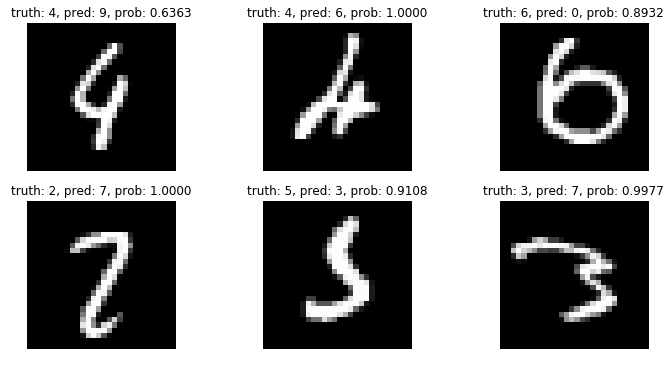

In [44]:
display_first_6_missclassified(model3)

**This are obvious mistakes! We should be able to do better!**

## Convolutional Neural Network

Transform images back into 2D shape:

In [45]:
x_train = x_train.reshape(60000, 28, 28, 1)
x_test = x_test.reshape(10000, 28, 28, 1)

Define a VGG16 like architecture:

In [72]:
def conv_block(inputs, filters, dropout_rate):
    x = Conv2D(filters, (3, 3), activation='relu')(inputs)
    x = Conv2D(filters, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(dropout_rate)(x)
    return x

inputs = Input(shape=(28, 28, 1))

x = conv_block(inputs, 32, 0.25)
x = conv_block(x, 64, 0.25)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(10, activation='softmax')(x)

model4 = Model(inputs=inputs, outputs=predictions)

model4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_54 (Dropout)         (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 10, 10, 64)        18496     
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 8, 8, 64)          36928     
__________

In [73]:
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model4.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

model4.fit(x_train, y_train, batch_size=32, epochs=10, verbose=1, validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 12s 202us/step - loss: 0.2594 - acc: 0.9167 - val_loss: 0.0512 - val_acc: 0.9821
Epoch 2/10
60000/60000 [==============================] - 11s 187us/step - loss: 0.0856 - acc: 0.9749 - val_loss: 0.0303 - val_acc: 0.9901
Epoch 3/10
60000/60000 [==============================] - 11s 186us/step - loss: 0.0614 - acc: 0.9812 - val_loss: 0.0240 - val_acc: 0.9922
Epoch 4/10
60000/60000 [==============================] - 11s 187us/step - loss: 0.0513 - acc: 0.9847 - val_loss: 0.0247 - val_acc: 0.9918
Epoch 5/10
60000/60000 [==============================] - 11s 187us/step - loss: 0.0469 - acc: 0.9863 - val_loss: 0.0248 - val_acc: 0.9918
Epoch 6/10
60000/60000 [==============================] - 11s 186us/step - loss: 0.0415 - acc: 0.9876 - val_loss: 0.0233 - val_acc: 0.9913
Epoch 7/10
60000/60000 [==============================] - 11s 186us/step - loss: 0.0375 - acc: 0.9893 - val_loss: 0.

In [76]:
sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model4.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

model4.fit(x_train, y_train, batch_size=32, epochs=6, verbose=1, validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 12s 203us/step - loss: 0.0222 - acc: 0.9926 - val_loss: 0.0156 - val_acc: 0.9950
Epoch 2/10
60000/60000 [==============================] - 11s 188us/step - loss: 0.0197 - acc: 0.9936 - val_loss: 0.0153 - val_acc: 0.9949
Epoch 3/10
60000/60000 [==============================] - 11s 188us/step - loss: 0.0174 - acc: 0.9946 - val_loss: 0.0154 - val_acc: 0.9951
Epoch 4/10
60000/60000 [==============================] - 11s 187us/step - loss: 0.0170 - acc: 0.9943 - val_loss: 0.0149 - val_acc: 0.9951
Epoch 5/10
60000/60000 [==============================] - 11s 188us/step - loss: 0.0161 - acc: 0.9948 - val_loss: 0.0143 - val_acc: 0.9952
Epoch 6/10
60000/60000 [==============================] - 11s 188us/step - loss: 0.0161 - acc: 0.9951 - val_loss: 0.0143 - val_acc: 0.9957
Epoch 7/10
60000/60000 [==============================] - 11s 188us/step - loss: 0.0155 - acc: 0.9953 - val_loss: 0.

Check the performance on the test dataset:

In [77]:
score = model4.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.013529261548061458
Test accuracy: 0.9954


Missclassified: 46 / 10000


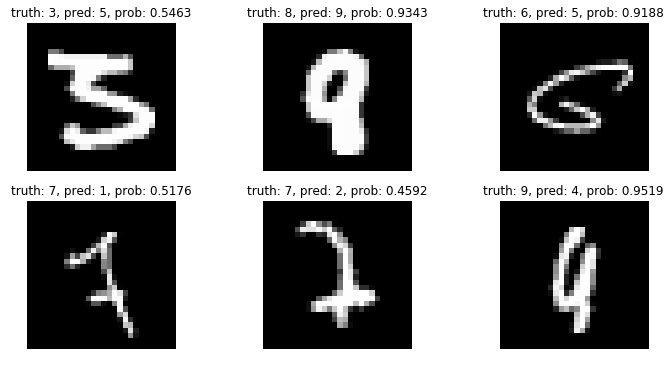

In [78]:
display_first_6_missclassified(model4)